In [2]:
import glob
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.rdMolAlign import CalcRMS

In [3]:
target_dirs = sorted(glob.glob('../Targets/*/'))
target_dirs.remove('../Targets/5HT2A_AF/')
target_dirs.remove('../Targets/BRD4_holo/')
#target_dirs.remove('../Targets/HDAC6/')

In [4]:
def get_rmsd(n):
    rmsd_list = []
    for target in target_dirs:
        test_sdf = glob.glob(f'{target}/*ligand*.sdf')[0]
        docked_sdf =  f'{target}/redock_{n}.sdf'

        mol = Chem.SDMolSupplier(test_sdf)[0]
        checks = Chem.SDMolSupplier(docked_sdf)
        rmsd_list.append(
            np.min([CalcRMS(Chem.RemoveHs(check), Chem.RemoveHs(mol)) 
                    for check in checks]))
    return rmsd_list

In [6]:
rmsd_8 = get_rmsd(8)
rmsd_32 = get_rmsd(32)
rmsd_8multi =get_rmsd('8-multi')
rmsd_32multi =get_rmsd('32-multi')

In [18]:
from scipy import stats

def signtest(a, b):
    group1 = np.array(a)
    group2 = np.array(b)

    # 正态性检验（Shapiro-Wilk）
    _, p1 = stats.shapiro(group1)
    _, p2 = stats.shapiro(group2)
    normal = p1 > 0.05 and p2 > 0.05  # 显著性水平α=0.05

    # 方差齐性检验（Levene）
    _, p_var = stats.levene(group1, group2)
    equal_var = p_var > 0.05

    # 选择检验方法并执行
    if normal and equal_var:
        t_stat, p_value = stats.ttest_ind(group1, group2)
        test_used = "独立样本t检验"
    else:
        u_stat, p_value = stats.mannwhitneyu(group1, group2)
        test_used = "曼-惠特尼U检验"

    # 输出结果
    print(f"正态性检验结果：组1 p值={p1:.3f}, 组2 p值={p2:.3f}")
    print(f"方差齐性检验p值={p_var:.3f}")
    print(f"选择的检验方法：{test_used}")
    print(f"显著性检验结果：p值={p_value:.3f}")

    # 判断显著性
    alpha = 0.05
    if p_value < alpha:
        print("结果显著，拒绝原假设（存在显著差异）")
    else:
        print("结果不显著，无法拒绝原假设")

In [19]:
signtest(rmsd_32, rmsd_8)
signtest(rmsd_32, rmsd_8multi)
signtest(rmsd_32, rmsd_32multi)

正态性检验结果：组1 p值=0.000, 组2 p值=0.000
方差齐性检验p值=0.807
选择的检验方法：曼-惠特尼U检验
显著性检验结果：p值=0.912
结果不显著，无法拒绝原假设
正态性检验结果：组1 p值=0.000, 组2 p值=0.000
方差齐性检验p值=0.782
选择的检验方法：曼-惠特尼U检验
显著性检验结果：p值=0.776
结果不显著，无法拒绝原假设
正态性检验结果：组1 p值=0.000, 组2 p值=0.000
方差齐性检验p值=0.973
选择的检验方法：曼-惠特尼U检验
显著性检验结果：p值=0.887
结果不显著，无法拒绝原假设


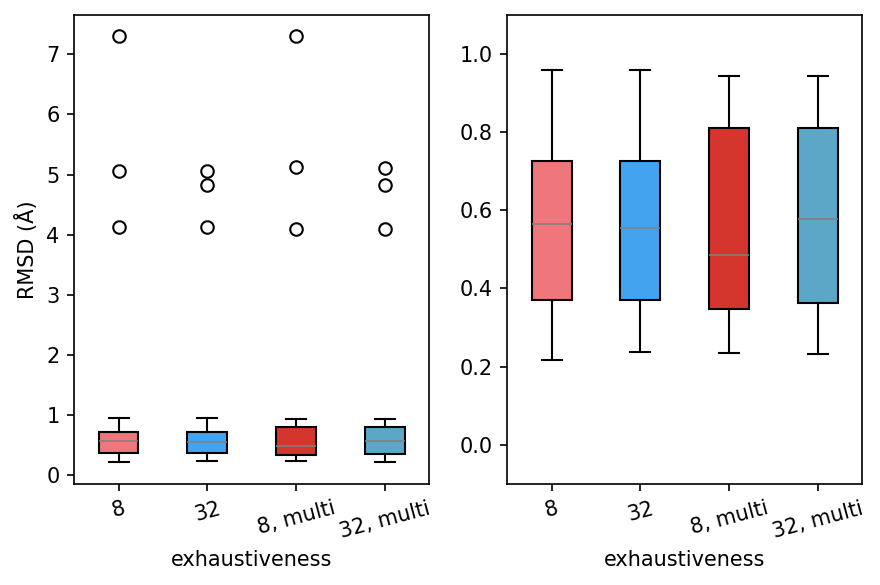

In [15]:
from matplotlib import pyplot as plt
from seaborn import boxplot

fig = plt.figure(dpi=150, figsize=(6, 4))

ax1 = plt.subplot(1,2,1)
bplt = plt.boxplot([rmsd_8, rmsd_32,rmsd_8multi, rmsd_32multi], 
                   medianprops={"color": 'grey', "linewidth": 0.75},
                   patch_artist=True)
for patch, color in zip(bplt['boxes'], ['#EF767B','#43A3EF', '#D4352D', '#5CA7C7']):
        patch.set(facecolor=color)
ax1.set_ylabel('RMSD (Å)')
ax1.set_xticklabels(['8', '32', '8, multi', '32, multi'], rotation=15)
ax1.set_xlabel('exhaustiveness')

ax2 = plt.subplot(1,2,2)
bplt = plt.boxplot([rmsd_8, rmsd_32,rmsd_8multi, rmsd_32multi],
                    notch=0,
                    sym=[],
                    vert=True,
                    medianprops={"color": 'grey', "linewidth": 0.75},
                    patch_artist=True)
for patch, color in zip(bplt['boxes'], ['#EF767B','#43A3EF', '#D4352D', '#5CA7C7']):
        patch.set(facecolor=color)
ax2.set_ylim([-0.1, 1.1])
ax2.set_xticklabels(['8', '32', '8, multi', '32, multi'], rotation=15)
ax2.set_xlabel('exhaustiveness')

plt.tight_layout()